In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path  # Handling OS paths more carefully
from sklearn.preprocessing import OneHotEncoder  # One Hot Encoding for the gender
from sklearn.model_selection import cross_val_score  # for verifying/comparing models
from sklearn.pipeline import Pipeline, FeatureUnion # To make a nice clean pipeline at the end
from sklearn.compose import ColumnTransformer,  make_column_selector # Same but handling column-specific stuff
from sklearn.impute import SimpleImputer # Just handling missing data quickly
from sklearn.base import BaseEstimator  # Trying to fit it all in a pipeline, seems like I need to inherit from this to make new features
from xgboost import XGBRegressor  # Boosted Decision Tree Regression
from sklearn.feature_selection import mutual_info_regression  # Check feature relevance


from matplotlib import pyplot as plt  # for making pics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/original-abalone-data/abalone.data
/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


In [2]:
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# !pip install ucimlrepo

# from ucimlrepo import fetch_ucirepo 

# # fetch dataset 
# abalone = fetch_ucirepo(id=1) 

# # data (as pandas dataframes)
# original_dataset = pd.concat([abalone.data.features, abalone.data.targets], axis = 1).rename({
#     'Whole_weight' : 'Whole weight',
#     'Shucked_weight' : 'Whole weight.1',
#     'Viscera_weight' : 'Whole weight.2',
#     'Shell_weight' : 'Shell weight'
# }, axis = 1)

In [4]:
data_dir = Path("/kaggle/input/playground-series-s4e4/")
train_dir = data_dir / "train.csv"
df_train = pd.read_csv(train_dir, index_col="id")
orig_data = pd.read_csv("/kaggle/input/original-abalone-data/abalone.data")
orig_data.columns = df_train.columns
df_train = pd.concat([df_train, orig_data], ignore_index=True)
X_train = df_train.drop("Rings", axis=1)
y_train = df_train["Rings"]
X_train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975


In [5]:
def score_model(X, y, model):
    score=cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_log_error",)
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [6]:
class feature_eng(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def set_output(self, *args, **kwargs):
        pass
    
    def get_feature_names_out(self, feature_names_in):
        return np.array(["log_size_norm", "shape_F", "shape_NF", "log_footprint_normal",
                         "frac_bled", "weird_feature",
                         "log_shell_weight_norm", "log_meat_weight_norm"])
                         # , "log_visc_weight_norm", "odd_height"])
                         #"log_footprint_large_height", "log_footprint_no_height"])
    
    def transform(self, X, y=None):
        height = X.loc[:, "Height"]
        length = X.loc[:,"Length"]
        diameter = X.loc[:,"Diameter"]
        shell = X.loc[:, "Shell weight"]
        meat = X.loc[:, "Whole weight.1"]
        visc = X.loc[:, "Whole weight.2"]
        weight = X.loc[:, "Whole weight"]
        female = X.loc[:,"Sex"] == "F"
        size_2d = length * diameter
        shape = length / (diameter + 1e-5)  # Protection against imputed zeros
        # X[: 0] / X[:, 1]
        normal_size = np.log(size_2d * height * (height <= 0.25) + 1e-7)# - np.log(weight)  # Watch out for the 1e-7 on normalization
#        odd_height = (2 * (height > 0.25) + (height < 1e-6))
#         large_height_size = np.log(size_2d * (height > 0.25) + 1e-6)
#         zero_height_size = np.log(size_2d * (height < 1e-5) + 1e-6)
        frac_bled = meat / visc
        weird_feature = np.log(weight) * np.log(meat)
        
        log_footprint = np.log(size_2d) - 2/3 * np.log(weight)
        log_shell_norm = np.log(shell)# - np.log(weight)
        log_meat_norm = np.log(meat)# - np.log(weight)
        # log_visc_norm = np.log(visc) - np.log(weight)
        
        shape_f = shape * female
        shape_nf = (1-female) * shape
        
        return np.stack([normal_size, shape_f, shape_nf, log_footprint,
                         frac_bled, weird_feature,
                        log_shell_norm, log_meat_norm], axis=1)
#                          , log_visc_norm, odd_height], axis=1)
#                          large_height_size, zero_height_size], axis=1)

feature_engineer = feature_eng()

In [7]:
class Logify(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def set_output(self, *args, **kwargs):
        pass
    
    def get_feature_names_out(self, feature_names_in):
        return np.array(["log_" + feature_name for feature_name in feature_names_in])
    
    def transform(self, X, y=None):
        return np.log(X.to_numpy())
        
logify = Logify()

In [8]:
# DataCard can be found at https://www.kaggle.com/datasets/kapturovalexander/ps-4-e-2-abalone-dataset-from-uci/data
num_cols = list(X_train.columns) # Separate out the only categorical
num_cols.remove("Sex")
oh_col =  ["Sex"]
feature_eng_cols = ["Length", "Diameter", "Height", "Sex", "Whole weight.1", "Whole weight", "Whole weight.2", "Shell weight"]
cols_to_drop = ["Sex_F", "Shell weight", "Whole weight.1", "Whole weight.2"]
cols_to_log = ["Whole weight"]  #, "Whole weight", "Whole weight.1", "Whole weight.2"]

numerical_cleaner = SimpleImputer(strategy="median")
oh_encoder_with_cleaning = Pipeline([
    ("cleaner", SimpleImputer(strategy="constant")),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers = [
        ("numerical", numerical_cleaner, num_cols),
        ("categorical", oh_encoder_with_cleaning, oh_col),
        ("log scale", logify, cols_to_log),
        ("feature_eng", feature_engineer, feature_eng_cols)# ,
        # ("column_dropper", "drop", cols_to_drop)
    ], verbose_feature_names_out = False
)
preprocessor.set_output(transform="pandas")

# # Some Log Scaling
# col_dropper = ColumnTransformer(transformers = [
#     ("log scale", logify, cols_to_log)
#     ], remainder="passthrough",  verbose_feature_names_out = False
# )
# col_dropper.set_output(transform="pandas")

# Get rid of redundancies
col_dropper = ColumnTransformer(transformers = [
    ("Drop_cols", "drop", cols_to_drop + cols_to_log)
    ], remainder="passthrough",  verbose_feature_names_out = False
)
col_dropper.set_output(transform="pandas")

X_train.head()
preprocessor.fit(X_train, y_train)
thing = preprocessor.transform(X_train)
check_output = thing

# col_dropper.fit(thing, y_train)
# thing = col_dropper.transform(thing)
# print(thing.head())

In [9]:
from sklearn.decomposition import PCA

def make_mi_scores(X, y):
    X = X.copy()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
preprocessor.fit(X_train)
col_dropper.fit(preprocessor.transform(X_train))
make_mi_scores(col_dropper.transform(preprocessor.transform(X_train)), y_train)

log_shell_weight_norm    0.672900
log_size_norm            0.577509
weird_feature            0.575480
log_Whole weight         0.568982
Height                   0.544199
Diameter                 0.536986
Length                   0.522371
log_meat_weight_norm     0.510434
shape_NF                 0.480154
Sex_I                    0.239597
frac_bled                0.187873
log_footprint_normal     0.139625
shape_F                  0.116872
Sex_M                    0.062174
Name: MI Scores, dtype: float64

In [10]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "log_shell_weight_norm",
    "log_size_norm",
    "Height",
    "Diameter",
    "log_meat_weight_norm",
    "Length",
#    "log_visc_weight_norm",
    "log_footprint_normal",
#     "frac_bled",
#     "weird_feature",
    "log_Whole weight"
#     "shape_F",
#     "shape_NF"

]

pca_transformer = ColumnTransformer(
    transformers = [
        ("PCA", PCA(), pca_features)
    ], remainder="passthrough", verbose_feature_names_out = False
)
pca_transformer.set_output(transform="pandas")

pca_transformer.fit(col_dropper.transform(preprocessor.transform(X_train)), y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('PCA', PCA(),
                                 ['log_shell_weight_norm', 'log_size_norm',
                                  'Height', 'Diameter', 'log_meat_weight_norm',
                                  'Length', 'log_footprint_normal',
                                  'log_Whole weight'])],
                  verbose_feature_names_out=False)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
log_shell_weight_norm,-0.381334,-0.013707,-0.144138,-0.114851,0.573239,-0.616886,-0.044471,-0.330606
log_size_norm,-0.375681,0.042799,-0.252619,-0.770909,-0.437400,0.060536,0.004827,-0.062516
Height,-0.361295,-0.079577,0.877414,-0.191004,0.152536,0.180004,-0.005244,0.033163
Diameter,-0.381623,0.064096,0.058626,0.387172,-0.400269,-0.243051,0.688856,-0.055712
log_meat_weight_norm,-0.379831,-0.032717,-0.302671,0.196320,0.299441,0.717041,0.108330,-0.330090
Length,-0.381803,0.064586,0.022924,0.402806,-0.390600,-0.088182,-0.714374,-0.128849
log_footprint_normal,-0.004456,0.989263,0.050900,-0.024287,0.112943,0.048742,0.002073,0.054975
log_Whole weight,-0.383683,-0.060470,-0.217692,0.068844,0.203975,0.003425,-0.037140,0.868334


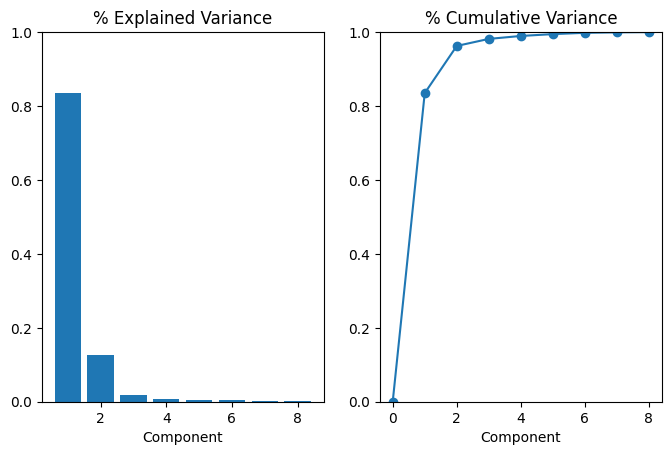

In [11]:
pca, X_pca, loadings = apply_pca(preprocessor.transform(X_train)[pca_features])
plot_variance(pca)
loadings

In [12]:
preprocessor.fit(X_train)
X_preproc = preprocessor.transform(X_train)
pca_transformer.fit(X_preproc)
X_pca = pca_transformer.transform(X_preproc)
col_dropper.fit(X_pca, y_train)
X_full = col_dropper.transform(X_pca)
make_mi_scores(X_full, y_train)

weird_feature    0.575336
pca0             0.554332
shape_NF         0.472983
pca5             0.243819
Sex_I            0.232904
frac_bled        0.187712
pca2             0.124815
shape_F          0.114448
pca3             0.064972
Sex_M            0.062048
pca1             0.036632
pca6             0.036198
pca4             0.033026
pca7             0.018233
Name: MI Scores, dtype: float64

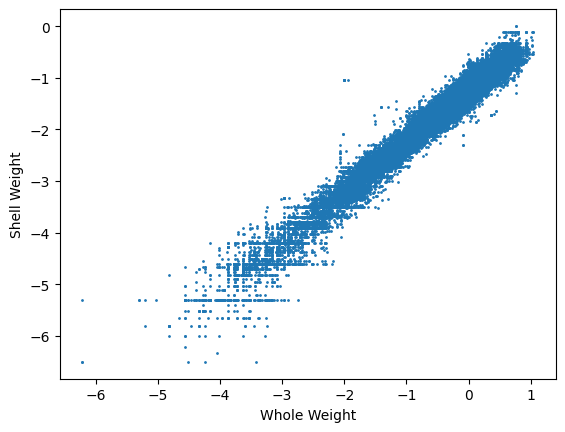

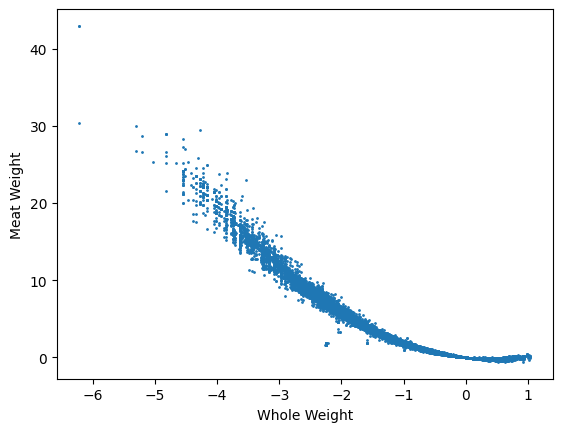

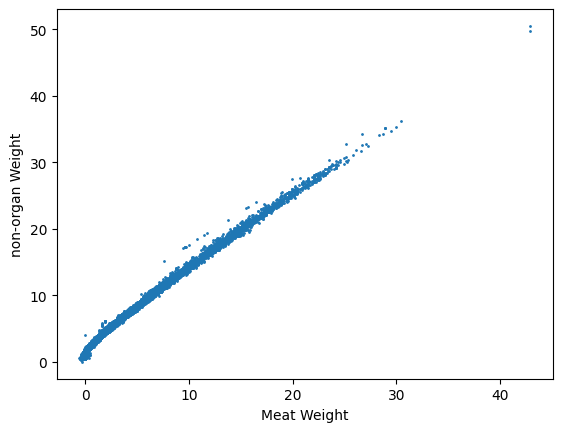

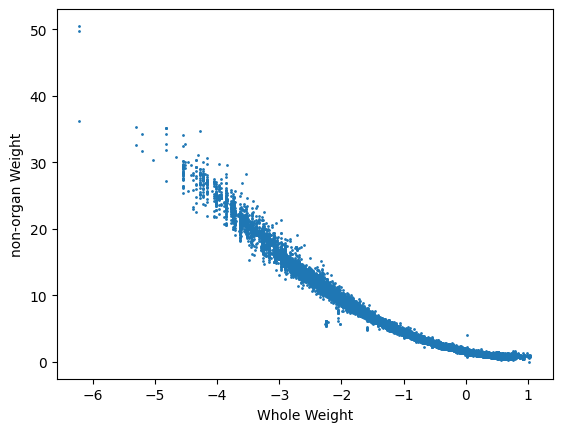

In [13]:
# Let's check for odd distributions
whole_weights = np.log(check_output.loc[:,"Whole weight"])
shell_weights = check_output.loc[:,"log_shell_weight_norm"]
whole_weights1 = np.log(check_output.loc[:,"Whole weight.1"])
whole_weights2 = np.log(check_output.loc[:,"Whole weight.2"])

whole_weights1 = whole_weights1 * whole_weights

non_organs = whole_weights1 - whole_weights2


plt.scatter(whole_weights, shell_weights, s=1)
plt.xlabel("Whole Weight")
plt.ylabel("Shell Weight")
plt.show()
plt.scatter(whole_weights, whole_weights1, s=1)
plt.xlabel("Whole Weight")
plt.ylabel("Meat Weight")
plt.show()
plt.scatter(whole_weights1, non_organs, s=1)
plt.xlabel("Meat Weight")
plt.ylabel("non-organ Weight")
plt.show()
plt.scatter(whole_weights, non_organs, s=1)
plt.xlabel("Whole Weight")
plt.ylabel("non-organ Weight")
plt.show()

8 zero entries
18 quarter inch entries


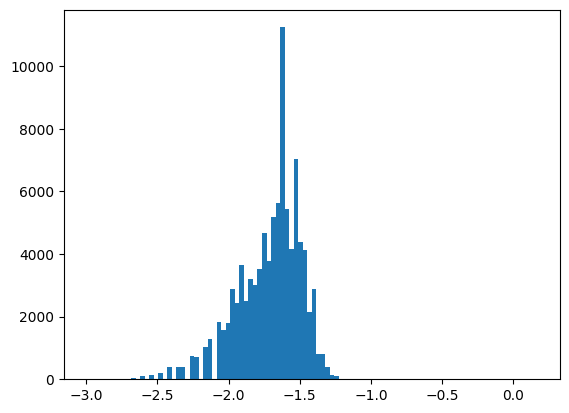

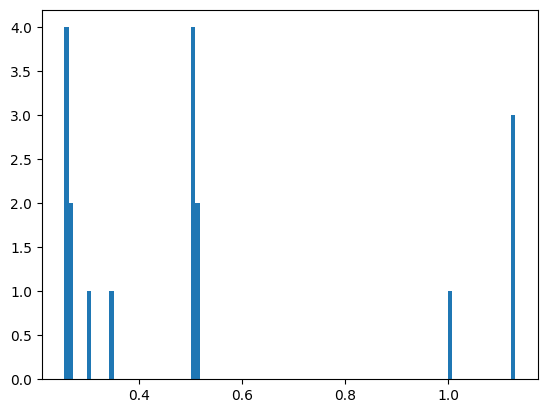

In [14]:
# There seem to be two outlyer classes, the zero height entries, and the entries of height > 0.25
# It seems likely some measurement apparatus gets rounded to the nearest quarter inch, but it's a small sample

heights = check_output.loc[:,"Height"]
print(np.sum(heights<1e-5), "zero entries")
print(np.sum(heights==0.25), "quarter inch entries")
plt.hist(np.log(heights+ np.exp(-3)), bins=100) 
plt.show()
plt.hist(heights[heights > 0.25], bins=100) 
plt.show()

/tmp/ipykernel_18/3786762642.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


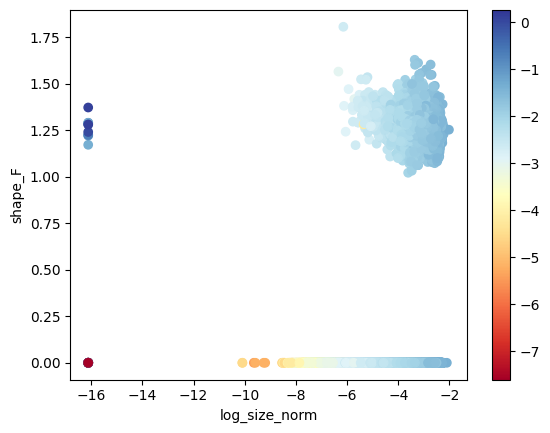

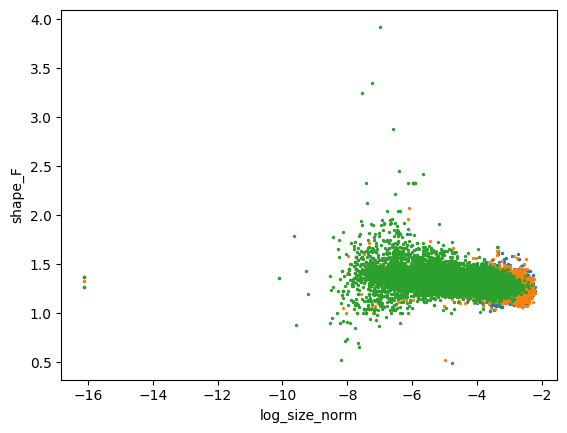

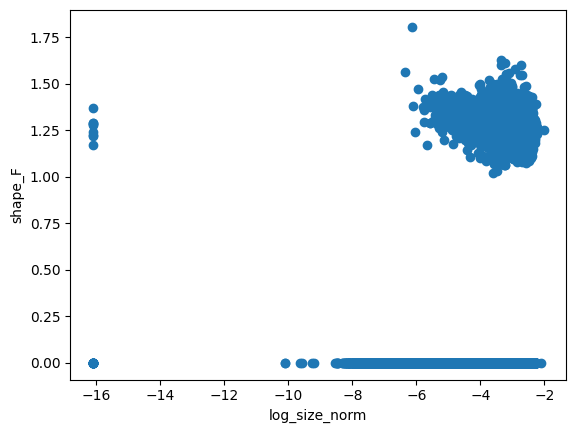

In [15]:
cm = plt.cm.get_cmap('RdYlBu')
x_axis = "log_size_norm"
y_axis = "shape_F"
sc = plt.scatter(*check_output.loc[:,[x_axis, y_axis]].to_numpy().T,
                 c=np.log(check_output.loc[:,"Height"]+0.0005), vmin=np.log(5e-4), vmax=np.log(1.3005), cmap=cm)
plt.colorbar(sc)
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()


x_axis = "log_size_norm"
y_axis = "shape_F"
heights = check_output.loc[:, "Height"]
height_filter = heights < 0.25 #  * (check_output.loc[:, "Sex_F"] > 0.5)
plt.scatter(*check_output.loc[height_filter * check_output.loc[:, "Sex_F"] > 0.5,
                              [x_axis, y_axis]].to_numpy().T, s=2)
plt.scatter(*check_output.loc[height_filter * check_output.loc[:, "Sex_M"] > 0.5,
                              [x_axis, "shape_NF"]].to_numpy().T, s=2)
plt.scatter(*check_output.loc[height_filter * (check_output.loc[:, "Sex_I"] > 0.5),
                              [x_axis, "shape_NF"]].to_numpy().T, s=2)
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()


x_axis = "log_size_norm"
y_axis = "shape_F"
plt.scatter(*check_output.loc[:,[x_axis, y_axis]].to_numpy().T)
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()

Let's make a pipeline with the model now

In [16]:
# import optuna

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         subsample=trial.suggest_float("subsample", 0.2, 1.0),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#     )
#     xgb = fit_model(**xgb_params)
#     return score_model(X_train, y_train, xgb)

# def fit_model(**xgb_params):
#     return Pipeline(steps=[("preprocessor", preprocessor),
#                                 # ("column_dropper", col_dropper),
#                                 ("column_dropper", col_dropper),
#                                 ("model", XGBRegressor(**xgb_params))
#                                ])


# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20)
# xgb_params = study.best_params
# print(xgb_params)

In [17]:
# Optuna result: {'max_depth': 5, 'learning_rate': 0.014197561242570616, 'n_estimators': 2545, 'min_child_weight': 8, 'colsample_bytree': 0.7691491931350338, 'subsample': 0.3964933911514999, 'reg_alpha': 0.07574237236608404, 'reg_lambda': 34.99198095051135}
# Alternate Optuna: {'max_depth': 8, 'learning_rate': 0.0015685078833230102, 'n_estimators': 6729, 'min_child_weight': 3, 'colsample_bytree': 0.4582191222372194, 'subsample': 0.7184289858135542, 'reg_alpha': 0.4999183459745948, 'reg_lambda': 1.1144461298838224}
xgb_params_optuna = dict(
    max_depth=8,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.015873381944667076,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1014,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=3,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.8578324335646342,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.41114541305140434,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=1,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=3,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
#     tree_method='hist',
#     max_bin=2048,
)
# Alternates:
# xgb_params_optuna2 = {'max_depth': 5, 'learning_rate': 0.014197561242570616, 'n_estimators': 2545, 'min_child_weight': 8, 'colsample_bytree': 0.7691491931350338, 'subsample': 0.3964933911514999, 'reg_alpha': 0.07574237236608404, 'reg_lambda': 34.99198095051135}
# xgb_params_optuna3 = {'max_depth': 8, 'learning_rate': 0.0015685078833230102, 'n_estimators': 6729, 'min_child_weight': 3, 'colsample_bytree': 0.4582191222372194, 'subsample': 0.7184289858135542, 'reg_alpha': 0.4999183459745948, 'reg_lambda': 1.1144461298838224}

# Current best
# xgb_params_optuna = {'max_depth': 4, 'learning_rate': 0.0133567593076709, 'n_estimators': 6663, 'min_child_weight': 4, 'colsample_bytree': 0.9369468341981182, 'subsample': 0.661669058257949, 'reg_alpha': 0.0006677300103599214, 'reg_lambda': 66.4477235917565}
model = XGBRegressor(**xgb_params_optuna)


# class Model_Wrapper(XGBRegressor):
# #     def __init__(self, *args, **kwargs):
# #         super().__init__(*args, **kwargs)
#     def predict(self, *args, **kwargs):
#         print(args[0])
#         print(args[0].shape)
#         return super().predict(*args, **kwargs)
#         # return np.array(np.rint(super().predict(*args, **kwargs)), dtype=int)

# model_wrapper = Model_Wrapper(**xgb_params)

full_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
#                                 ("PCA", pca_transformer),
                                ("column_dropper", col_dropper),
                                ("model", model)  # _wrapper)
                               ])
# full_pipeline.fit(X_train, y_train)
# full_pipeline.predict(X_train)


# full_pipeline.fit(X_train, y_train)
# test = full_pipeline.predict(X_train)
# print(test)
# print(test.dtype)

score = score_model(X_train, y_train, full_pipeline)
print("Current score:", score)
# score with dropping: 0.15153557883211813
# Current best: 0.15089389394938152

Current score: 0.15089389394938152


When I'm ready to submit, just uncomment the below and add the model. I might also have to see about including the data pipeline stuff, but I'll deal with that later

In [18]:
test_dir = data_dir / "test.csv"
X_test = pd.read_csv(test_dir, index_col="id")

full_pipeline.fit(X_train, y_train)
prediction = full_pipeline.predict(X_test)

output = pd.DataFrame({"id": X_test.index, "Rings": prediction})
output.to_csv("my_submission.csv", index=False)
print("Submission successfully saved")

Submission successfully saved


Credit to the Beginner and Intermediate Machine Learning Courses and the Feature Engineering Course for most of this design.